<h1 style = "text-align:center; font-size:300%">Home Loan Approval Prediction</h1>

---

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')

import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import plot_tree

# Loading Data

In [2]:
data = pd.read_csv('Modified_Loan_Data.csv')

In [3]:
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
Gender,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
Married,No,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes
Dependents,Zero,One,Zero,Zero,Zero,Two,Zero,Three or more,Two,Two
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate,Graduate,Not Graduate,Graduate,Graduate,Graduate
Self_Employed,No,No,Yes,No,No,Yes,No,No,No,No
ApplicantIncome,5849,4583,3000,2583,6000,5417,2333,3036,4006,3200
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0,4196.0,1516.0,2504.0,1526.0,700.0
LoanAmount,128.0,128.0,66.0,120.0,141.0,267.0,95.0,158.0,168.0,70.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0,360.0
Credit_History,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes


---

# Data Pre-processing

## 1. Take a Copy From Data

In [4]:
# Take a copy from data
data_ml = data.copy()

## 2. Remove Ineffective Features 

**Based on the analysis in the previous Notebook:**
- `Gender`, `Self_Employed`, and `Dependents` features don't have an impact on the Loan Approval, so let's remove them.
- For the `Loan Amount Term` column, almost 90 % of the data have Term 360, so this column is not useful in Training the Model, so let's remove it.

In [5]:
# Drop Self_Employed, Gender, and Dependents columns
data_ml.drop(['Self_Employed','Gender', 'Dependents', 'Loan_Amount_Term'], axis=1, inplace=True)

## 3. Rearrange Columns

In [6]:
data_ml = data_ml[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Married',
                   'Education', 'Credit_History', 'Property_Area', 'Loan_Status']]

## 4. Splitting data

In [7]:
# Splitting data to X (Features) and y (label)
X = data_ml.drop('Loan_Status', axis = 1)
y = data_ml['Loan_Status']

In [8]:
# Splitting data to X_train, y_train, X_test, and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size  = 0.15, random_state = 42, stratify = y)

In [9]:
print('X training shape = ', X_train.shape)
print('Y training shape = ', y_train.shape)
print('X test shape     = ', X_test.shape)
print('Y test shape     = ', y_test.shape)

X training shape =  (501, 7)
Y training shape =  (501,)
X test shape     =  (89, 7)
Y test shape     =  (89,)


## 5. Transform Data (Encoding and Rescaling)

### 5.1. Encoding the Target 

In [10]:
# Create the label encoder
le = LabelEncoder()

# Fit the data
le.fit(y_train)

LabelEncoder()

In [11]:
# Transform the y training data
y_train_transformed = le.transform(y_train)

# Transform the y testing data
y_test_transformed = le.transform(y_test)

### 5.2. Transform the Features

In [12]:
# Creating a list including the names of numerical data
num_features = data_ml.select_dtypes(include='number').columns.tolist()

# Creating a list including the names of categorical data
cat_features = data_ml.select_dtypes(include = 'object').columns.tolist()
cat_features.remove('Loan_Status')

print(f'Numerical Features  : {num_features}')
print(f'Categorical Features: {cat_features}')

Numerical Features  : ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
Categorical Features: ['Married', 'Education', 'Credit_History', 'Property_Area']


In [13]:
# numerical transformer
nume_transformer = Pipeline(steps=[('standardscaler', StandardScaler())])

# categorical transformer
cat_transformer = Pipeline(steps=[('onehotencoder', OneHotEncoder())])

# Combining between categorical transformer and numerical transformer in one pipeline
preprocessor = ColumnTransformer(transformers=[
                                                ('num', nume_transformer, num_features),
                                                ('cat', cat_transformer, cat_features)
                                              ])

# Fit and transform your data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['ApplicantIncome', 'CoapplicantIncome',
                                  'LoanAmount']),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['Married', 'Education', 'Credit_History',
                                  'Property_Area'])])

In [14]:
# Transform the X training data
X_train_transformed = preprocessor.transform(X_train)

# Transform the X testing data
X_test_transformed = preprocessor.transform(X_test)

# Modeling (Decision Tree Classifier)

In [15]:
def cross_validation_score(estimator, X_train, y_train, score='precision', n=5):
    
    '''This function is to validate the model'''
    
    validate = cross_val_score(estimator, X_train, y_train, scoring = score, cv = n)
    
    print(f'Cross Validation Scores: {validate} \n')
    print(f'Standard Deviation of Scores: {validate.std()} \n')
    print(f'Mean of Scores: {validate.mean()}')

In [16]:
def hyperparameter_tunning(estimator, X_train, y_train, param_grid, score='precision', n=5):
    
    '''This function is used to find the best set of hyperparameters for the model to optimize its performance'''
    
    # Perform grid search
    grid_search = GridSearchCV(estimator = estimator, 
                               param_grid = param_grid,
                               scoring = score,
                               cv = n)
    
    # Fit the data
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Print the best parameters and score
    print(f'Best parameters: {best_params} \n')
    print(f'Best score: {best_score}')
    
    # best estimator
    best_estimator = grid_search.best_estimator_
    
    return best_estimator

In [17]:
def model_evaluation(estimator, X, y, color = 'Reds'):
    
    ''' This function is used to evaluate the model through on classification report  and confusion matrix'''
    
    # classification report
    y_pred = estimator.predict(X)
    print(classification_report(y, y_pred, zero_division=0), '\n ')
    
    #confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y, y_pred), cmap = color, annot = True)
    plt.xlabel('Predicted', size = 12, weight = 'bold')
    plt.ylabel('Actual', size = 12, weight = 'bold')
    plt.title('Confusion Matrix', weight = 'bold')
    plt.show()

In [18]:
def roc_auc_curve_score(estimator, X, y):
    
    '''This function plots the roc-auc curve and calculate the model ROC-AUC score '''
    
    # y predicted value
    #y_pred = estimator.predict(X)
    
    # y predicted probability
    y_proba = estimator.predict_proba(X)
    
    # ROC_AUC Score
    score = roc_auc_score(y, y_proba[:, 1])
    
    # ROC Curve
    fpr ,tpr ,thresholds = roc_curve(y, y_proba[:, 1])
    
    plt.figure(figsize = (8, 5))
    plt.plot(fpr, tpr, label = 'ROC_AUC Score (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc = "lower right")
    plt.show()

In [30]:
def visualize_decision_tree(estimator, feature_names, class_names = ['No', 'Yes']):
    
    '''This function is used to visualize the decision tree '''
    
    plt.figure(figsize=(20, 10))
    plot_tree(estimator, feature_names=feature_names, class_names=class_names, filled=True, rounded=True, fontsize=10)
    plt.show()

## 1. Creating The Model

In [20]:
# Instantiating Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42)

# Fit the data
tree.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(random_state=42)

In [21]:
# Make predictions on the training set
y_pred_training = tree.predict(X_train_transformed)

# Calculate accuracy of training set
accuracy = accuracy_score(y_train_transformed, y_pred_training)
print(f'Training Accuracy: {accuracy}')

Training Accuracy: 1.0


> **Does the model have overfitted? let's discover it by cross-validation.**

## 2. Cross Validation

In [22]:
cross_validation_score(tree, X_train_transformed, y_train_transformed, n=10)

Cross Validation Scores: [0.8        0.82352941 0.80555556 0.86111111 0.77777778 0.79411765
 0.82352941 0.78378378 0.76666667 0.76923077] 

Standard Deviation of Scores: 0.02778333826186103 

Mean of Scores: 0.8005302134713899


> **The model has overfitting, so let's improve it by tuning the hyperparameters.**

## 3. Hyperparameter Tuning

**max_depth:**
* sklearn default value is None
* If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* It controls the splitting of the tree. 

**min_samples_split:** 
* sklearn default value is 2
* The minimum number of samples required to split an internal node

**min_samples_leaf:**
* sklearn default value is 1
* The minimum number of samples required to be at a leaf node

In [23]:
# Define the hyperparameter grid
param_grid = {
                'max_depth': [2, 4, 6, 8],
                'min_samples_split': [1, 2, 3, 4],
                'min_samples_leaf': [1, 2, 3]
             }

# Best Decision Tree
best_tree = hyperparameter_tunning(tree, X_train_transformed, y_train_transformed, param_grid, n=10)

Best parameters: {'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2} 

Best score: 0.8005034176134572


> **After tuning the hyperparameter, the model seems to have improved more in learning from the training dataset.**

## 4. Model Evaluation (Training)

              precision    recall  f1-score   support

           0       0.94      0.44      0.60       154
           1       0.80      0.99      0.88       347

    accuracy                           0.82       501
   macro avg       0.87      0.72      0.74       501
weighted avg       0.84      0.82      0.80       501
 
 


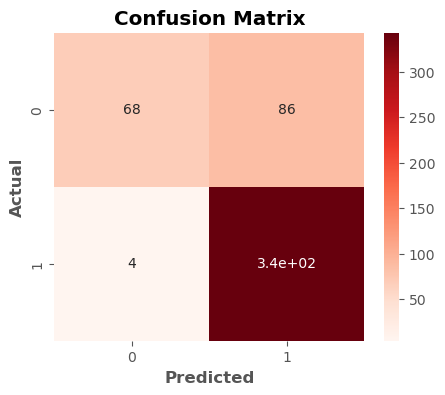

In [24]:
# Evaluate the model through on classification report  and confusion matrix for training data
model_evaluation(best_tree, X_train_transformed, y_train_transformed)

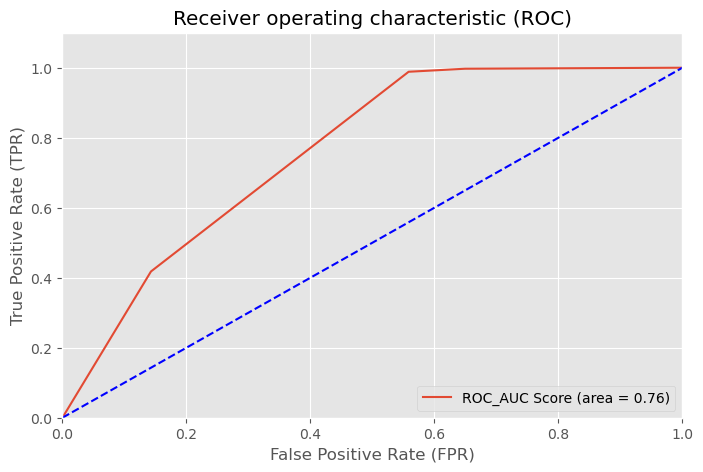

In [25]:
# Plotting the roc-auc curve and calculating the model ROC-AUC score for training data
roc_auc_curve_score(best_tree, X_train_transformed, y_train_transformed)

## 5. Model Evaluation (Testing)

              precision    recall  f1-score   support

           0       0.92      0.44      0.60        27
           1       0.80      0.98      0.88        62

    accuracy                           0.82        89
   macro avg       0.86      0.71      0.74        89
weighted avg       0.84      0.82      0.80        89
 
 


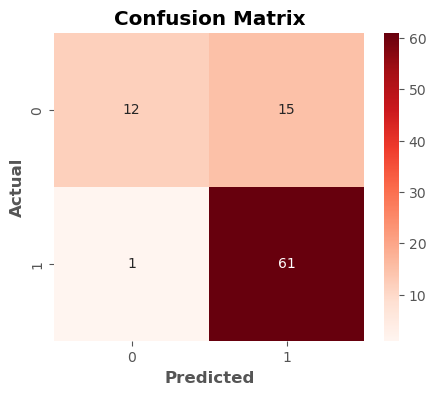

In [26]:
# Evaluate the model through on classification report  and confusion matrix for test data
model_evaluation(best_tree, X_test_transformed, y_test_transformed)

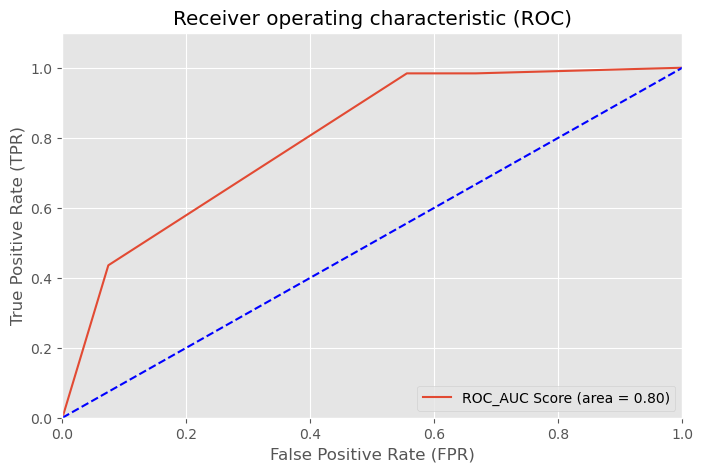

In [27]:
# Plotting the roc-auc curve and calculating the model ROC-AUC score for test data
roc_auc_curve_score(best_tree, X_test_transformed, y_test_transformed)

## 6. Visualizing Decision Tree

In [28]:
# Access feature names directly from the transformers
numeric_feature_names = preprocessor.named_transformers_['num']['standardscaler'].get_feature_names_out()
categorical_feature_names = preprocessor.named_transformers_['cat']['onehotencoder'].get_feature_names_out()

# Concatenate feature names
feature_names = list(numeric_feature_names) + list(categorical_feature_names)
feature_names

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Married_No',
 'Married_Yes',
 'Education_Graduate',
 'Education_Not Graduate',
 'Credit_History_No',
 'Credit_History_Yes',
 'Property_Area_Rural',
 'Property_Area_Semiurban',
 'Property_Area_Urban']

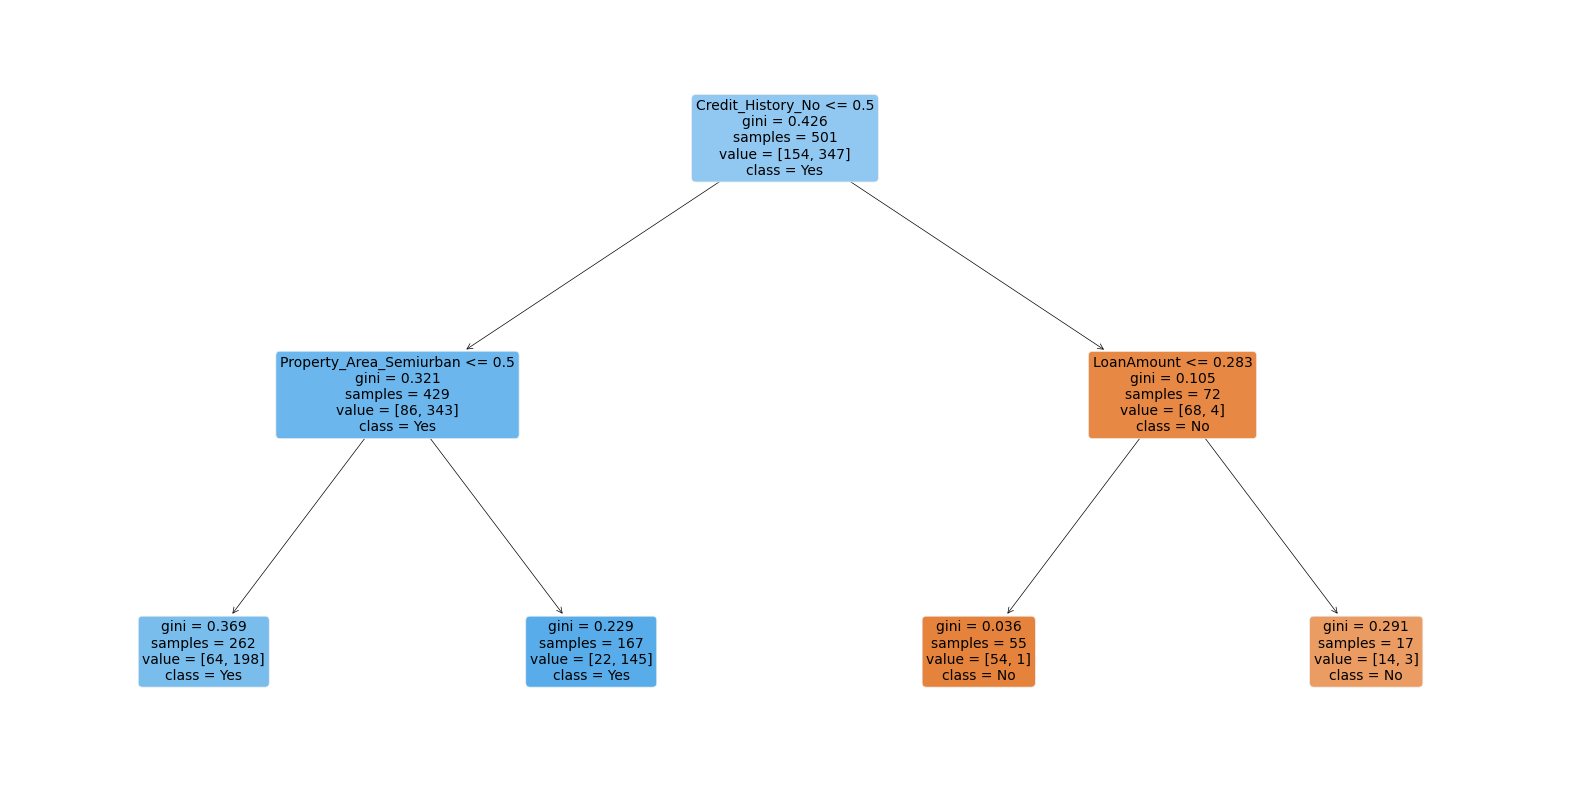

In [31]:
visualize_decision_tree(best_tree, feature_names)

---

# DONE